# Include NAN values as "Ambiguous" in CNN 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
data = pd.read_csv("../../core/data/tweet_global_warming.csv", encoding="latin")
print("Full dataset: {}".format(data.shape[0]))
data['existence'].fillna(value='ambiguous', inplace = True) #replace NA's in existence with "ambiguous"
data['existence'].replace(('Y', 'N'), ('Yes', 'No'), inplace=True) #rename so encoder doesnt get confused
data = data.dropna() #now drop NA values
print("dataset without NaN: {}".format(data.shape[0]))
X = data.iloc[:,0]
Y = data.iloc[:,1]
print("Number of unique words: {}".format(len(np.unique(np.hstack(X)))))

#one hot encoding = dummy vars from categorical var 
#Create a one-hot encoded binary matrix 
#N, Y, Ambig
#1, 0, 0 
#0, 1, 0
#0, 0, 1

#encode class as integers 
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y) 

#convert integers to one hot encoded
Y = np_utils.to_categorical(encoded_Y)

Full dataset: 6090
dataset without NaN: 6087
Number of unique words: 5541


In [4]:
data.shape

(6087, 3)

In [5]:
#one hot example
print("Ambiguous data point: ")
print (data.iloc[6083])
print ("One hot coding for ambiguous: {}".format(Y[6083]))

Ambiguous data point: 
tweet                   Virginia to Investigate Global Warming Scienti...
existence                                                       ambiguous
existence.confidence                                                    1
Name: 6086, dtype: object
One hot coding for ambiguous: [ 0.  0.  1.]


average tweet length: 
111 characters


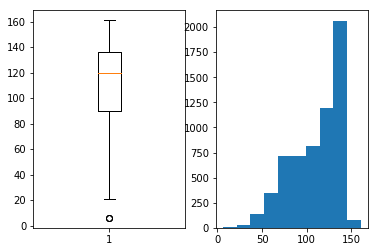

In [6]:
# Summarize review length
print("average tweet length: ")
result = list(map(len, X))
print("{:.0f}".format(np.mean(list(map(len, X)))), 'characters')
plt.subplot(121)
plt.boxplot(result)
plt.subplot(122)
plt.hist(result, bins=10)
plt.show()

In [7]:
print ("Training data: ")
print ("X: ", X.shape,"Y: ", Y.shape)
print ("Classes: ", np.unique(Y))
print("Number of unique words: ", len(np.unique(np.hstack(X)))) #based on encoding this is the number of unique words? Categorized by frequency 

# Summarize review length
print("Tweet length: ")
print("Mean %.0f words (std: %.2f)" % (np.mean(result), np.std(result)))

Training data: 
X:  (6087,) Y:  (6087, 3)
Classes:  [ 0.  1.]
Number of unique words:  5541
Tweet length: 
Mean 111 words (std: 27.51)


In [5]:
top_words = 1000
max_words = 150
word_vec = 32 #dont understand why we want a 32 bit vector
test_split = 0.3

#convert X to ints (y is already done)
token = Tokenizer(num_words=top_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ', char_level=False, oov_token=None)
token.fit_on_texts(texts=X)
X = token.texts_to_sequences(texts=X)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=test_split)

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# create the model
model = Sequential()
model.add(Embedding(top_words+1, word_vec, input_length=max_words)) #is it better to preconvert using word to vec? 
model.add(Convolution1D(filters=word_vec, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(3, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model.summary())

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128,
    verbose=1)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 32)           32032     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               600250    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 753       
Total params: 636,139
Trainable params: 636,139
Non-trainab